Parte 4 do curso Machine Learning: Introdução a classificação com SKLearn da Alura

Transcrição das aulas do instrutor Guilherme Silveira

Já conhecemos dois algoritmos diferentes que funcionam de base para estimadores que tentam modelar como nossos dados são classificados. Agora, com o foco em resolver outro problema, usaremos um tipo novo de estimador.

Usaremos um novo arquivo para esta aula. Trata-se de um banco de dados fictício em que cada linha representa um carro à venda em uma loja online. Os carros são de diversos donos diferentes, e alguns desses carros foram vendidos e outros não. Abaixo temos os cinco primeiros carros da tabela.

    milage_per_year model_year	price      sold
    21801	        2000	    30941.02	yes
     7843	        1998	    40557.96	yes
     7109	        2006	    89627.50	no
    26823	        2015	    95276.14	no
     7935	        2014	   117384.68	yes

A coluna "sold" representa os carros que foram ou não vendidos: "yes" para os vendidos e "no" para os não. Temos três features para cada um dos carros: a primeira, "milage_per_year" representa quantas milhas o carro fez por ano; "model_year" representa o ano de cada modelo (que é diferente do ano de fabricação); e, por fim, temos o "price", ou seja, o preço de venda cada carro.

    Nota: Estamos trabalhando com a medida em milhas, e não com quilômetros, pois os dados são americanos.

De acordo com estas variáveis, tentaremos classificar se um carro será vendido ou não. Pensando no negócio da empresa, com esse tipo de informação, ela poderia ajudar seus clientes a concretizar sua venda, criando condições mais atrativas para possíveis compradores com base em dados reais e de acordo com as características de cada carro.

Como de costume, criaremos um novo notebook do Python, importaremos o pandas e faremos a leitura do arquivo .csv com a nossa tabela. Também exibiremos os primeiros 5 itens com head(). 

In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/4d1d4a16ccbf6ea4e0a64a38a24ec884/raw/afd05cb0c796d18f3f5a6537053ded308ba94bf7/car-prices.csv"
dados = pd.read_csv(uri)
dados.head()

,Unnamed: 0,mileage_per_year,model_year,price,sold
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


Perceba que temos uma coluna não nomeada, mas ela não tem qualquer utilidade e pode ser ignorada. 

Como nos projetos anteriores, renomearemos as colunas para português. Para tanto usaremos dados.rename() e passaremos as colunas que devem ser renomeadas. Por fim, imprimiremos novamente os cinco primeiros itens da lista. 

In [2]:
a_renomear = { 
    'mileage_per_year' : 'milhas_por_ano',
    'model_year' : 'ano_do_modelo',
    'price' : 'preco',
    'sold' :'vendido'
}
dados = dados.rename(columns=a_renomear)
dados.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


Ainda precisamos modificar os valores de "vendido" ("yes" e "no"), que ainda estão em inglês. Mas na verdade, melhor do que passarmos para o português, podemos usar o formato 0 ou 1, que é o padrão quando estamos trabalhando com uma classificação binária.

Por meio de a_trocar atribuiremos 0 a no e 1 para yes. Em seguida, solicitaremos o mapeamento da coluna vendidos de acordo com esse novo dicionário. Atribuiremos esse mapeamento à coluna dados.vendido, sobrescrevendo-a, e imprimiremos os primeiros 5 elementos da lista:

In [3]:
a_trocar = {
    'no': 0,
    'yes': 1
}
dados.vendido = dados.vendido.map(a_trocar)
dados.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido
0,0,21801,2000,30941.02,1
1,1,7843,1998,40557.96,1
2,2,7109,2006,89627.50,0
3,3,26823,2015,95276.14,0
4,4,7935,2014,117384.68,1


Já temos os dados em português e os valores binários, mas ainda temos algumas alterações a realizar na coluna "ano_do_modelo". Os anos estão com uma diferença pequena entre eles; por exemplo "2000" e "1998", há uma diferença de dois anos, mas se pensarmos 2/2000 x 100 = 0,1 , portanto o peso de dois anos é 0,1%.

No caso desse projeto, ao invés de usarmos o ano do modelo, usaremos a idade desde a fabricação do carro, ou seja, quão velho ou novo é um determinado veículo. Criaremos a coluna idade_do_modelo, que será dados.ano_do_modelo. Para tanto, precisaremos coletar o ano atual, por exemplo 2021, menos a data de fabricação do carro.

Importaremos a função datetime do módulo datetime, e solicitaremos que ele colete o dia de hoje via today(). Em seguida, chamaremos o atributo year, que corresponde ao ano atual. Portanto ano_atual - dados.ano_do_modelo nos fornecerá a idade do carro. Para finalizar, imprimiremos os cinco primeiros itens.

In [4]:
from datetime import datetime

ano_atual = datetime.today().year
dados['idade_do_modelo'] = ano_atual - dados.ano_do_modelo
dados.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido,idade_do_modelo
0,0,21801,2000,30941.02,1,21
1,1,7843,1998,40557.96,1,23
2,2,7109,2006,89627.50,0,15
3,3,26823,2015,95276.14,0,6
4,4,7935,2014,117384.68,1,7


Agora, na coluna idade_do_modelo, temos a idade dos veículos em relação ao ano atual. Desse modo, temos todas as features necessárias para prosseguirmos com o projeto. Entretanto, por mais que milhas_por_ano seja uma unidade de medida válida, no Brasil estamos acostumados com quilômetros. Portanto, criaremos uma coluna nova que apresentará esses valores em quilômetros (km_por_ano). Sabendo que cada milha equivale a 1,60934 km, faremos a seguinte operação:

In [5]:
dados ['km_por_ano'] = dados.milhas_por_ano * 1.60934
dados.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido,idade_do_modelo,km_por_ano
0,0,21801,2000,30941.02,1,21,35085.22134
1,1,7843,1998,40557.96,1,23,12622.05362
2,2,7109,2006,89627.50,0,15,11440.79806
3,3,26823,2015,95276.14,0,6,43167.32682
4,4,7935,2014,117384.68,1,7,12770.11290


Nesse ponto, podemos deletar as colunas que não serão utilizadas com drop(). Além dos nomes das colunas em um array, precisaremos passar o argumento columns e o eixo vertical (axis=1), pois essa função, por padrão, remove linhas. 

In [6]:
dados = dados.drop(columns = ["Unnamed: 0", "milhas_por_ano", "ano_do_modelo"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,21,35085.22134
1,40557.96,1,23,12622.05362
2,89627.50,0,15,11440.79806
3,95276.14,0,6,43167.32682
4,117384.68,1,7,12770.11290


Como resultado teremos, finalmente, somente as colunas que serão úteis no nosso trabalho.

Poderíamos ter realizado esse procedimento anteriormente, mas é interessante fazermos passo a passo, explorando os dados e percebendo o que de fato está ocorrendo em nosso projeto.

O próximo passo é classificar todos os dados. Começaremos separando X (as colunas que representam nossas features) e Y (se o carro foi vendido ou não):

In [7]:
x = dados[["preco", "idade_do_modelo", "km_por_ano"]]
y = dados["vendido"]

No projeto anterior, usávamos a classificação do LinearSVC. Vamos reaproveitar esse código e testar esse estimador:

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

x = dados[["preco", "idade_do_modelo", "km_por_ano"]]
y = dados["vendido"]

SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = LinearSVC(max_iter=100000)
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia foi 58.00%


C:\Users\Resource\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Tivemos uma acurácia de 58.00%, mas ainda não temos base comparativa para sabermos o quão bom ou ruim é esse resultado.

Em nosso projeto de venda de carros, executamos o LinearSVC para sabermos qual seria a porcentagem de acurácia, e tivemos um resultado de 58.00%.

Para definirmos se esse resultado é bom ou ruim, ainda precisamos de uma base comparativa, estipulando qual seria o mínimo de acerto aceitável - por exemplo, se todos os palpites fossem 0 ou 1.

Já fizemos esse procedimento anteriormente por meio de np.ones(), criando um array de 1 com o número de elementos que queríamos utilizar. Como esse é um processo bastante recorrente, as bibliotecas possuem ferramentas que facilitam nosso trabalho.

Como podemos verificar na documentação da biblioteca SKLearn, ele possui um estimador conhecido como DummyClassifier, que é basicamente o que o nome diz: um classificador "bobo".

Isso porque ele possui várias estratégias bem simples de classificação, e que podem ser passadas como parâmetro:

    class sklearn.dummy.DummyClassifier(strategy=’stratified’, random_state=None, constant=None)[source]
    
Para nossos testes, primeiramente importaremos esse classificador e criaremos a variável dummy como padrão. Em seguida, trabalharemos com os métodos tradicionais fit() e predict(), exatamente como no LinearSVC.

Depois do treino, o DummyClassifier() irá prever os resultados e imprimiremos sua acurácia na tela: 

In [9]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(treino_x, treino_y) 
previsoes = dummy.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100 
print("A acurácia do dummy foi %.2f%%" % acuracia)


A acurácia do dummy foi 58.00%


Tivemos um resultado de 58.00%. Nosso algoritmo LinearSVC fez igual (58.00%).

Portanto, existe uma igualdade do LinearSVC (com 100.000 de máximo de iterações) em relação do DummyClassifier. Contudo, a estratégia utilizada pelo DummyClassifier é estratificada ou (stratified), ou seja, proporcional; se temos 30% de itens da classe 0 e 70% da classe 1, o estimador manterá esse padrão em sua classificação.

Deixaremos explícito em nosso código que é essa a estratégia utilizada modificando dummy para dummy_stratified e executaremos novamente o código.

In [10]:
from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier()
dummy_stratified.fit(treino_x, treino_y)
previsoes = dummy_stratified.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia do dummy foi %.2f%%" % acuracia)

A acurácia do dummy foi 58.00%


Testaremos uma outra estratégia do DummyClassifier, o argumento most_frequent, ou "mais frequente".

In [11]:
dummy_mostfrequent = DummyClassifier(strategy = "most_frequent")
dummy_mostfrequent.fit(treino_x, treino_y)
previsoes = dummy_mostfrequent.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia do dummy mostfrequent foi %.2f%%" % acuracia)

A acurácia do dummy mostfrequent foi 58.00%


Como obtemos uma acurácia igual, para as estratégias dummy_stratified e dummy_mostfrequent, nosso baseline será 58 % que queremos superar.

Nosso código está repetitivo em relação ao cálculo da taxa de acurácia, e há formas melhores de gerar esse número. Como este é um procedimento muito comum em classificadores, uma das funções disponíveis nessas bibliotecas é o score, que retorna a acurácia do modelo que estamos testando.

Portanto, ao invés de chamarmos o predict, usaremos o score, que precisará receber teste_x e teste_y como parâmetro para realizar as comparações. Além disso, multiplicaremos o resultado por 100 para obtermos o valor em porcentagem e imprimiremos a acurácia na tela:

In [12]:
dummy_stratified = DummyClassifier()
dummy_stratified.fit(treino_x, treino_y)
acuracia = dummy_stratified.score(teste_x, teste_y) * 100

print("A acurácia do dummy stratified foi %.2f%%" % acuracia)

A acurácia do dummy stratified foi 58.00%


Com isso, não precisamos importar o accuracy_score(), reduzindo uma linha do nosso código.

Agora tentaremos detectar padrões não necessariamente lineares para nossos dados. Poderíamos cogitar a ideia de utilizar o SVC, mas é importante lembrar que ele (além de outros estimadores) não pode ser usado diretamente com dados em várias escalas diferentes.

Aprendemos no projeto anterior que precisamos reescalar nossos dados utilizando o StandardScaler() do pré-processamento.

Reaproveitaremos o código do projeto anterior e o revisaremos em busca de adaptações necessárias. Nele, temos o SEED fixo, a quebra dos dados de treino e teste e a separação do treino raw (os dados antes de serem reescalados).

Em seguida, o StandardScaler(), a partir da média, desloca esses dados e divide pelo desvio padrão, criando um intervalo. Com esse treino, os dados crus são transformados em treino_x e teste_x, que então são utilizados no treino e no teste do nosso modelo. Por fim, imprimimos a acurácia: 

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

SEED = 5
np.random.seed(SEED)
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

scaler = StandardScaler()
scaler.fit(raw_treino_x)
treino_x = scaler.transform(raw_treino_x)
teste_x = scaler.transform(raw_teste_x)

modelo = SVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia foi 77.48%


Com esse resultado, tivemos em ganho muito grande de acurácia em relação à baseline - aproximadamente 19,5 % de ganho absoluto e 33,6 % de ganho relativo.

No entanto, ainda não estamos compreendendo quais critérios o algoritmo usa para definir qual carro será vendido e qual não.

Não é trivial estudarmos a estrutura interna desses algoritmos para entendermos por que estão sendo tomadas determinadas decisões. Algoritmos de classificação como o Support Vector Machine são difíceis de estudar e interpretar, e, por esse motivo, são apelidados de "caixa preta" (ou black box, em inglês).

Mas será que existem classificadores que conseguem exibir com clareza quais são as regras de decisão que são tomadas para chegar na classificação? Na verdade sim, e aprenderemos quais são eles nos próximos passos do nosso projeto.

Até o momento, utilizamos dois classificadores reais baseados em Support Vector Machine, o LinearSVC e SVC. Usamos, ainda, dois classificadores simples (Dummy Classifiers) para definir nosso baseline.

Com o SVC, depois de reescalarmos os dados, a acurácia tem um ganho impressionante. Porém, ainda não temos um algoritmo de classificação que nos forneça suas regras internas para que possamos entender como certas decisões são tomadas.

Existem algoritmos que exibem uma sequência de decisões com base nos dados fornecidos, como por exemplo um carro ter menos quilometragens rodadas e ser mais novo, e como essas decisões influenciam na classificação, em uma espécie de "árvore de decisões".

Não à toa, tais classificadores são chamados de decision tree classifiers. Existem vários algoritmos desse tipo, e nesse curso usaremos o DecisionTreeClassifier padrão do próprio SKLearn.

A forma de utilizarmos esse classificador é bastante parecida com tudo o que fizemos até agora: vamos copiar o código que criamos para o SVC(), utilizando, ao invés disso, o DecisionTreeClassifier(), que deverá ser importado do módulo sklearn.tree.

Lembrando que você não precisa ter todas essas importações visíveis, porque elas já foram realizadas anteriormente. Porém, elas serão mantidas no código para que você possa colocá-las facilmente em um arquivo Python.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

SEED = 5
np.random.seed(SEED)
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = DecisionTreeClassifier()
modelo.fit(raw_treino_x, treino_y)
previsoes = modelo.predict(raw_teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia foi 73.32%


Antes de executarmos o código, vamos revisá-lo: definimos o SEED, separamos os dados de teste e de treino, reescalamos esses dados e criamos o DecisionTreeClassifier()

Com a execução, teremos uma acurácia de 73,24 %, menor do que a anterior de 77,48 %. 

Porém, nosso foco agora é compreender como as decisões estão sendo tomadas. Para tanto, usaremos outra funcionalidade do módulo sklearn.tree para exportar a visualização gráfica da árvore de decisões. O nome dessa função é export_graphviz.

Chamaremos a visualização gráfica do nosso modelo. Porém, como estamos no cloud do Google, pode ser necessário instalar algumas bibliotecas.

Precisamos, antes, importar a biblioteca graphviz utilizando !pip install graphviz no início do nosso arquivo. Podemos ainda explicitar a versão da biblioteca a ser usada - neste caso, a mais recente é a versão 0.10.

Até o presente momento, quando atualizamos a biblioteca gráfica (Seaborn), bastava atualizar uma bilioteca do Python. O Graphviz usa um programa na linha de comando, chamado graphviz, portanto precisamos instalar isso em nosso Linux, Mac ou Windows.

Com o *Jupyter* depois de instalar temos que colocar no path via painel de controle o caminho  
C:\Users\username\anaconda3\Lib\site-packages\graphviz (substituir pelo o caminho da sua instalação)

Para modificar o caminho vá até Painel de Controle > Sistema (abre a tela "Sobre") > Configurações Relacionadas > Configurações Avançadas de Sistema (abre a tela "Propriedades do Sistema") > Variáveis de Ambiente > Variáveis de usuário para username > Path > Editar > Novo

In [16]:
#!pip install graphviz==0.10

from sklearn.tree import export_graphviz
#import graphviz

dot_data = export_graphviz(modelo, out_file=None)
grafico = graphviz.Source(dot_data)
grafico

Assim poderemos finalmente imprimir o gráfico da nossa árvore de decisões. Porém, como ele estará muito grande, não conseguiremos interpretá-lo com facilidade. Uma das características que podem ser trabalhadas para otimizar a interpretação de uma árvore de decisões é a profundidade (max_depth): quantas condições diferentes queremos que o algoritmo analise antes de fazer a classificação.

Em modelo = DecisionTreeClassifier(), modificaremos a max_depth para 2:

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

SEED = 5
np.random.seed(SEED)
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = DecisionTreeClassifier(max_depth=2)
modelo.fit(raw_treino_x, treino_y)
previsoes = modelo.predict(raw_teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia foi 76.84%


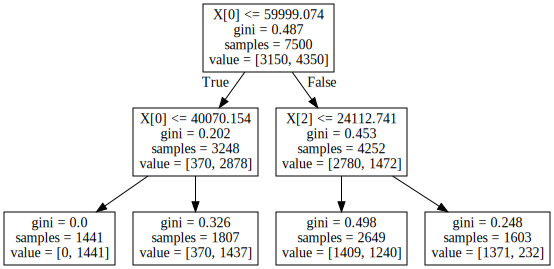

In [18]:
dot_data = export_graphviz(modelo, out_file=None)
grafico = graphviz.Source(dot_data)
grafico

Contudo, ela ainda não é muito simples de ser lida. Por exemplo, X[0] corresponde aos dados X na primeira coluna, e X[1] na segunda. Ou seja, precisaremos conferir as correspondências na tabela o tempo todo, o que não é muito prático.

Para melhorarmos esse ponto, passaremos alguns parâmetros. Por exemplo, o nome das features será x.columns. Também deixaremos os quadros coloridos e com bordas arredondadas (filled = True, rounded _ True). Por fim, adicionaremos o nome das classes: sim, que equivale a 1; e não, que equivale a 0. Isso porque, por padrão, a árvore de decisão não exporta o nome das classes automaticamente.

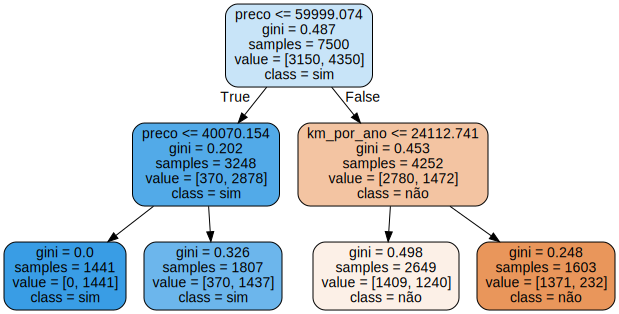

In [19]:
from sklearn.tree import export_graphviz
import graphviz

features = x.columns
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,
                          class_names = ["não", "sim"])
grafico = graphviz.Source(dot_data)
grafico

Agora temos uma visualização mais clara, com as cores azul e laranja indicando tipos diferentes de classificação: se um preço for menor que um valor específico, o item será direcionado para a classe "sim", por exemplo, simbolizada pela cor azul. No caso de classificação negativa, teremos a cor laranja. O branco representa uma espécie de incerteza quanto à classificação.

No primeiro quadro, temos preco: 59999.074. Se o preço for menor ou igual a este valor, o carro será enquadrado na classe "sim", e nosso algoritmo tomará a decisão de que ele será vendido. Se o preço for menor ou igual a 40070.156, o algoritmo também decidirá que ele será vendido. A decisão também será positiva se o preço for maior que este valor, mas com um pouco menos de certeza (representada por um tom mais claro de azul).

Se o preço for maior que 59999.074, o classificador tomará uma decisão negativa. A próxima decisão será tomada de acordo com km_por_ano: se este valor for maior que 24112.742, o algoritmo decidirá que o carro não será vendido; se for menor ou igual, a decisão será a mesma, mas com uma certeza menor.

Existem outras informações na árvore de decisão, por exemplo samples, que nos mostra quantos dados são enquadrados em determinada situação. No primeiro quadro ,o valor de samples será de 7500, pois essa é a quantidade total de dados que disponibilizamos; no segundo quadro da esquerda (em azul), teremos 3248, com o restante (4252) no quadro da esquerda (em tom salmão); e assim por diante.

Para medir se vale a pena quebrar a árvore em dois pedaços em cada uma das decisões, o algoritmo utiliza diversos parâmetros. Um deles é o gini, que também é exibido nesses quadros. Não entraremos em detalhes sobre o funcionamento desses parâmetros no momento, pois eles serão abordados no curso de __[otimização de algoritmos](https://cursos.alura.com.br/course/machine-learning-otimizacao-de-modelos-atraves-de-hiperparametros)__.

Vamos fazer outro teste, alterando o máximo de profundidade (max_depth) para 3:

In [20]:
modelo = DecisionTreeClassifier(max_depth=3)
modelo.fit(raw_treino_x, treino_y)
previsoes = modelo.predict(raw_teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

A acurácia foi 79.28%


Neste caso, além de obtermos uma acurácia melhor, nosso gráfico será um pouco maior, com uma profundidade máxima de 3 decisões antes dos resultados. 

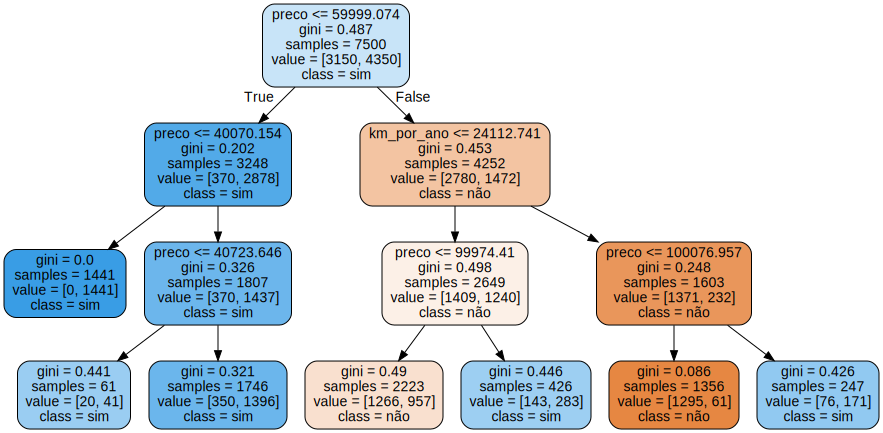

In [21]:
features = x.columns
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,
                          class_names = ["não", "sim"])
grafico = graphviz.Source(dot_data)
grafico

Os algoritmos do tipo árvore de decisão possuem diversos parâmetros, como o critério para separar os nós da árvore, o mínimo de samples para separar um nó ou definir um nó final, assim como a profundidade.

Sabendo disso, também podemos tentar encontrar um conjunto de parâmetros que otimize nosso classificador - uma questão mais aprofundada em machine learning e que abordaremos mais tarde na carreira.

Por enquanto, nosso trabalho é simplesmente carregaros dados, manipulá-los, treinar modelos e verificar, com base em treino e teste, quão bom esse modelo é.

Como exemplo, temos essa árvore de profundidade 3, com resultados muito bons para nossos objetivos (principalmente em comparação com a baseline).

Você pode explorar muitos outros classificadores na __[documentação do Sklearn](https://scikit-learn.org/stable/supervised_learning.html)__, estudar cada um deles e tentar aplicá-los em seu projeto.